In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DataSet/cucumber/function2/VegetableImages.zip

Streaming output truncated to the last 5000 lines.
  inflating: VegetableImages/train/Radish/0018.jpg  
  inflating: VegetableImages/train/Radish/0019.jpg  
  inflating: VegetableImages/train/Radish/0020.jpg  
  inflating: VegetableImages/train/Radish/0021.jpg  
  inflating: VegetableImages/train/Radish/0022.jpg  
  inflating: VegetableImages/train/Radish/0023.jpg  
  inflating: VegetableImages/train/Radish/0024.jpg  
  inflating: VegetableImages/train/Radish/0025.jpg  
  inflating: VegetableImages/train/Radish/0026.jpg  
  inflating: VegetableImages/train/Radish/0027.jpg  
  inflating: VegetableImages/train/Radish/0028.jpg  
  inflating: VegetableImages/train/Radish/0029.jpg  
  inflating: VegetableImages/train/Radish/0030.jpg  
  inflating: VegetableImages/train/Radish/0031.jpg  
  inflating: VegetableImages/train/Radish/0032.jpg  
  inflating: VegetableImages/train/Radish/0033.jpg  
  inflating: VegetableImages/train/Radish/0034.jpg  
  inflating: VegetableImages/train/Radish/0035.j

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
data_dir = '/content/VegetableImages'
TRAIN = 'train'
VAL = 'validation'
TEST = 'test'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 15000 images under train
Loaded 3000 images under validation
Loaded 3000 images under test
Classes: 
['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(class_names)

15

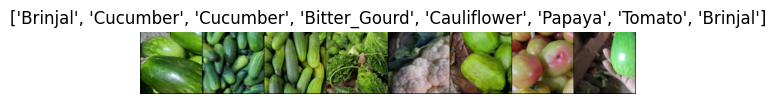

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training

    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]

        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
VGG_types = {
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
}

class VGG_net(nn.Module):
    def __init__(self,input_channels, num_classes = 2):
        super(VGG_net,self).__init__()
        self.in_channels = input_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16']) #create our conv layers
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
                     nn.ReLU(),
                     nn.Dropout(p=0.5),
                     nn.Linear(4096,4096),
                     nn.ReLU(),
                     nn.Dropout(p=0.5),
                     nn.Linear(4096,num_classes) #sizeInputImage = 224, divided by num Maxpool : 224 / 2⁷ = 7
        )
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1) #flatten our convlayers
        x = self.fcs(x)
        return x
    def create_conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        for layer in architecture :
            if type(layer) is int:
                out_channels = layer
                layers += [nn.Conv2d(in_channels = in_channels,out_channels = out_channels,
                                     kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                                     nn.BatchNorm2d(layer),
                                     nn.ReLU()]
                in_channels = layer #for the next itteration
            elif layer == 'M':
                layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]
        return nn.Sequential(*layers,  )

In [ ]:
input_channels = 3
num_classes = len(class_names)
model = VGG_net(input_channels, num_classes)

# Hiển thị thông tin summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs, save_path):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        # Save model after each epoch
        epoch_save_path = save_path.format(epoch)
        torch.save(vgg.state_dict(), epoch_save_path)
        print("Model saved at:", epoch_save_path)

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
model_save_path = '/content/drive/MyDrive/silverline/cucumber/function2/VGG16_torch_model.pt'
num_epochs = 100
history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, model_save_path)

Epoch 0/100
----------
Training batch 900/937.5
Validation batch 0/375

<ipython-input-13-9eaf662b15cc>:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Validation batch 300/375
Epoch 0 result: 
Avg loss (train): 0.2697
Avg acc (train): 0.2711
Avg loss (val): 0.1918
Avg acc (val): 0.4653
----------

Model saved at: /content/drive/MyDrive/silverline/cucumber/function2/VGG16_torch_model.pt
Epoch 1/100
----------
Training batch 900/937.5
Validation batch 300/375
Epoch 1 result: 
Avg loss (train): 0.2160
Avg acc (train): 0.4263
Avg loss (val): 0.1406
Avg acc (val): 0.6027
----------

Model saved at: /content/drive/MyDrive/silverline/cucumber/function2/VGG16_torch_model.pt
Epoch 2/100
----------
Training batch 900/937.5
Validation batch 300/375
Epoch 2 result: 
Avg loss (train): 0.1926
Avg acc (train): 0.4829
Avg loss (val): 0.1252
Avg acc (val): 0.6477
----------

Model saved at: /content/drive/MyDrive/silverline/cucumber/function2/VGG16_torch_model.pt
Epoch 3/100
----------
Training batch 900/937.5
Validation batch 300/375
Epoch 3 result: 
Avg loss (train): 0.1742
Avg acc (train): 0.5455
Avg loss (val): 0.0966
Avg acc (val): 0.7550
------

In [ ]:
eval_model(model, criterion)

Evaluating model
----------
Test batch 0/375

/tmp/ipykernel_26/1779223084.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 300/375
Evaluation completed in 0m 22s
Avg loss (test): 0.0028
Avg acc (test): 0.9947
----------


/tmp/ipykernel_26/642155024.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


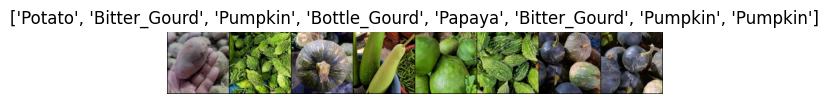

Prediction:


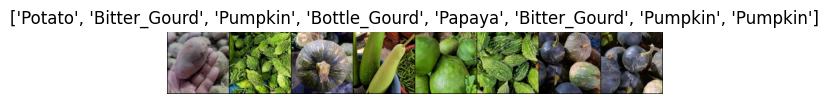

Ground truth:


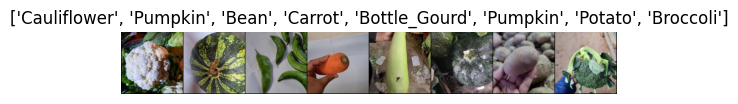

Prediction:


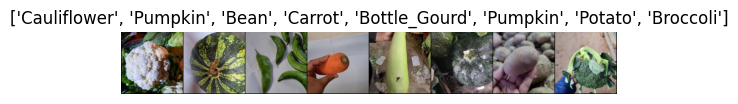

In [ ]:
visualize_model(model, num_images=10)